In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from env import get_db_url

In [2]:
# Find all of the "Single Family Residential" properties from 2017.
sql = """
select 
bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
from properties_2017
join propertylandusetype using (propertylandusetypeid)
where propertylandusedesc = "Single Family Residential"
"""

df = pd.read_sql(sql, get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
# What's the percentage of nulls?
df.isna().mean()

bedroomcnt                      0.000005
bathroomcnt                     0.000005
calculatedfinishedsquarefeet    0.003941
taxvaluedollarcnt               0.000229
yearbuilt                       0.004337
taxamount                       0.002063
fips                            0.000000
dtype: float64

In [4]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

In [5]:
# If we drop all rows containing any null, how much data do we have left?
round(df.dropna().shape[0] / df.shape[0], 4)

0.9941

In [6]:
df.shape[0]

2152863

In [7]:
# I'm comfortable dropping the rows with nulls
df = df.dropna()

In [8]:
df.columns.tolist()

['bedrooms',
 'bathrooms',
 'area',
 'tax_value',
 'year_built',
 'taxamount',
 'fips']

In [9]:
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-----------------")

bedrooms
3.0     962944
4.0     633608
2.0     334221
5.0     150671
6.0      25117
1.0      22895
7.0       4792
0.0       4397
8.0       1103
9.0        290
10.0       118
11.0        34
13.0        15
12.0        12
14.0         7
15.0         5
18.0         3
16.0         2
25.0         1
Name: bedrooms, dtype: int64
-----------------
bathrooms
2.00     942463
3.00     422398
1.00     412582
2.50     142827
4.00      82039
1.50      31157
3.50      28464
5.00      28306
4.50      19474
6.00      10717
5.50       6201
7.00       4381
0.00       4274
8.00       1681
6.50       1330
9.00        707
7.50        382
10.00       322
11.00       145
8.50        108
12.00        73
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
19.50         1
14.50         1
32.00         1
19.00         1
Name: bathrooms, dtype: int64
-----------

### Takeaways so far:
- Bedrooms can be an integer
- Bathrooms can stay a float to keep the .5 bathrooms
- Year built, FIPS, and taxvaluedollarcnt can be converted to integers w/o data loss

In [10]:
# 100% of calculatedfinishedsquarefeet can be converted to int w/o data loss
(df.area == df.area.astype(int)).mean()

1.0

In [11]:
# 100% of taxvaluedollarcnt can lose the deicimal and be OK
(df.tax_value == df.tax_value.astype(int)).mean()

1.0

In [12]:
(df.bathrooms == df.bathrooms.astype(int)).mean()

0.8925192794249229

In [13]:
# fips, yearbuilt, and bedrooms can be integers
df["fips"] = df["fips"].astype(int)
df["year_built"] = df["year_built"].astype(int)
df["bedrooms"] = df["bedrooms"].astype(int)
df["tax_value"] = df["tax_value"].astype(int)
df["area"] = df["area"].astype(int)

In [14]:
df.dtypes

bedrooms        int64
bathrooms     float64
area            int64
tax_value       int64
year_built      int64
taxamount     float64
fips            int64
dtype: object

## Above Data Wrangling now lives in `wrangle.py`
- There's also a CSV caching layer in the wrangle_zillow function.

# Histogram All The Things!

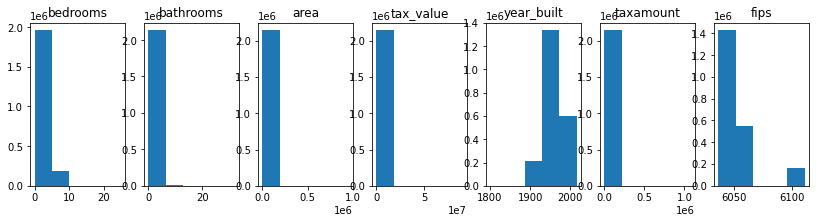

In [15]:
plt.figure(figsize=(16, 3))

# List of columns
for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


## Just Because It's Automatable Doesn't Mean It's Legible :)

bedrooms


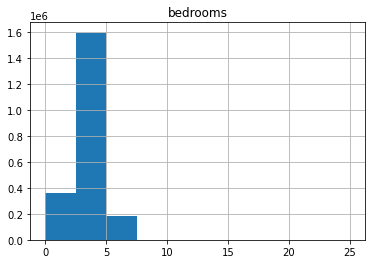

bathrooms


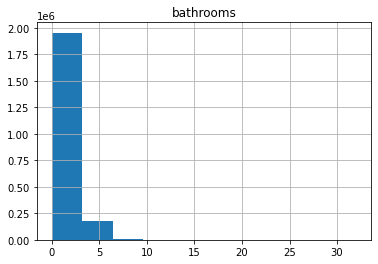

area


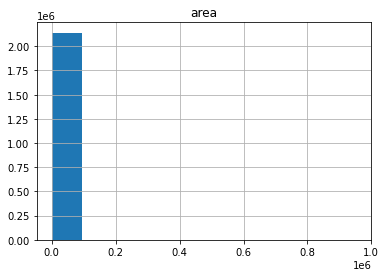

tax_value


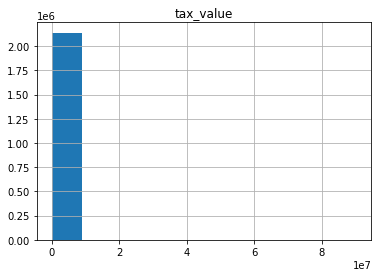

year_built


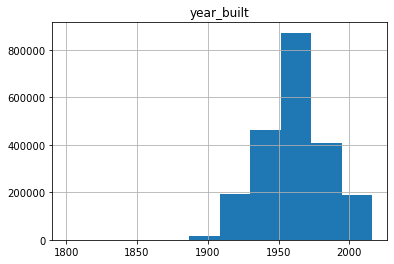

taxamount


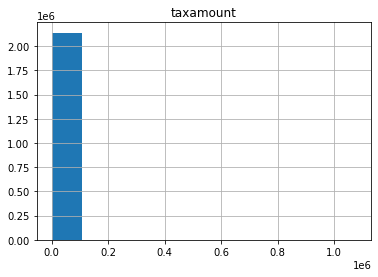

fips


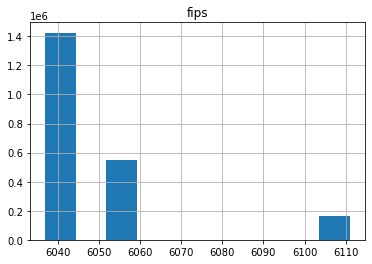

In [16]:
for col in df.columns:
    print(col)
    plt.title(col)
    df[col].hist()
    plt.show()

## Let's See about handling outliers
- I'm going to remove properties that are larger than half a football field, 25000 sqft (46 records)
- Those >= 25_000 sqft properties average a tax value north of $21m. 
- I'm going 

In [17]:
# A football field is 57,600 square feet
df.area.sort_values(ascending=False).head(10)

849924     952576
1689332    531118
1432166     63692
830510      59220
530834      52503
1327785     45891
401550      42831
1657947     39170
2080790     37634
430684      37472
Name: area, dtype: int64

In [18]:
df[df.area >= 25_000].tax_value.mean()

21324849.826086957

In [19]:
# Most Zillow customers share more in common with you and me than a movie star with 25 bedrooms.
df.bedrooms.value_counts()

3     962944
4     633608
2     334221
5     150671
6      25117
1      22895
7       4792
0       4397
8       1103
9        290
10       118
11        34
13        15
12        12
14         7
15         5
18         3
16         2
25         1
Name: bedrooms, dtype: int64

In [20]:
df.bathrooms.sort_values(ascending=False).head(30)

1657947    32.0
1114403    20.0
2051558    20.0
26485      20.0
1174755    20.0
1618393    20.0
701366     20.0
32114      19.5
2135273    19.0
1758193    18.0
1553895    18.0
1273779    18.0
570561     18.0
1012171    18.0
253517     18.0
799516     18.0
1811787    18.0
572169     17.0
1671890    17.0
843041     17.0
1144383    17.0
818240     16.0
1432079    16.0
549141     16.0
1866663    16.0
154074     16.0
1151694    16.0
2138637    16.0
1316950    16.0
1090763    16.0
Name: bathrooms, dtype: float64

## Manual Outlier Detection and Filtering

> WHO is actually using Zillow? Is it folks with 25 bedrooms? Or folks who shop closer to you and me?


In [21]:
# What percentage of properties have 6 or less bathrooms?
df[df.bathrooms <= 6].shape[0] / df.shape[0]

0.9956481414424116

In [22]:
# What percentage of properties have 6 or less bedrooms?
df[df.bedrooms <= 6].shape[0] / df.shape[0]

0.9970180844626875

In [23]:
# What percentage of properties are less than $2m in tax value?
df[df.tax_value < 1_500_000].shape[0] / df.shape[0]

0.9673507815730515

In [24]:
# Import the wrangle_zillow where I've dropped some outliers already
from wrangle import wrangle_zillow

In [25]:
df = wrangle_zillow()

In [26]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
0,4,2.0,3633,296425,2005,6941.39,6037
1,3,4.0,1620,847770,2011,10244.94,6037
2,3,2.0,2077,646760,1926,7924.68,6037
3,0,0.0,1200,5328,1972,91.60,6037
4,0,0.0,171,6920,1973,255.17,6037


bedrooms


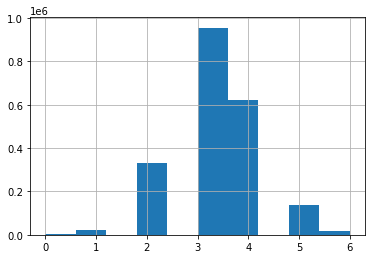

bathrooms


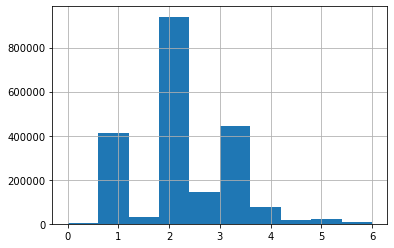

area


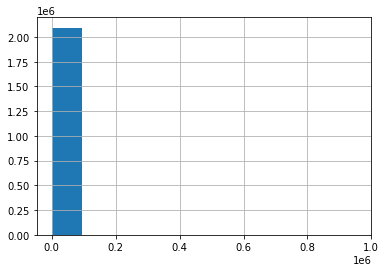

tax_value


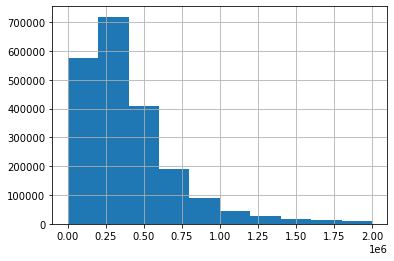

year_built


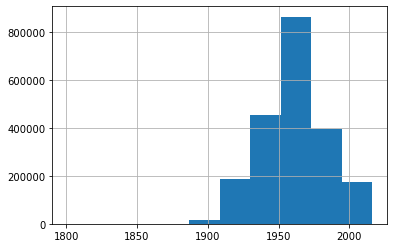

taxamount


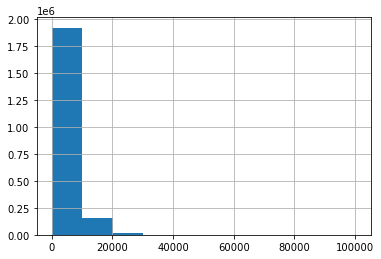

fips


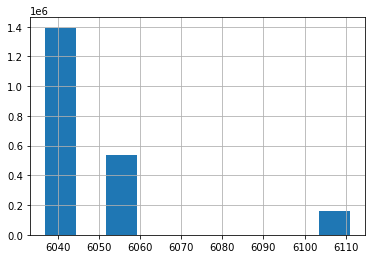

In [27]:
for col in df.columns:
    print(col)
    df[col].hist()
    plt.show()